## 목표  
#### 건물을 3D 시각화하는 가장 쉬운 방법을 구현해보자  

### 패키지

In [5]:
import pandas as pd
import geopandas as gpd

In [6]:
import pydeck as pdk
from IPython.core.display import display
from IPython.display import display
import ipywidgets as widgets

pydeck 설치 및 기본 예제는 "10_gridmap" 참조

### 데이터 준비

1. https://osmbuildings.org/ 사이트에 접속 > Data 메뉴 > Free Download 클릭   
  : 지도 페이지 (https://overpass-turbo.eu/) 로딩됨  (왼쪽의 URL로 바로 접속해도 됨)     


2. 지도를 원하는 위치와 축척으로 맞춤   
  : 지도 좌측 상단의 검색창에서 "seoul" 등으로 검색해도 됨     
  ❗ 건물이 너무 많으면, 즉 파일 용량이 크면 컴퓨터가 힘들어 합니다   
  
  
3. Run 버튼을 클릭하면 지도 상에 추출될 건물 위치들이 표시됨


4. Export 버튼을 클릭 > Data 탭 > "download/copy as GeoJSON" 링크를 클릭하면 "export.geojson" 파일이 다운로드됨   
  : 파일을 주피터 내의 적당한 경로로 옮겨준다  
 


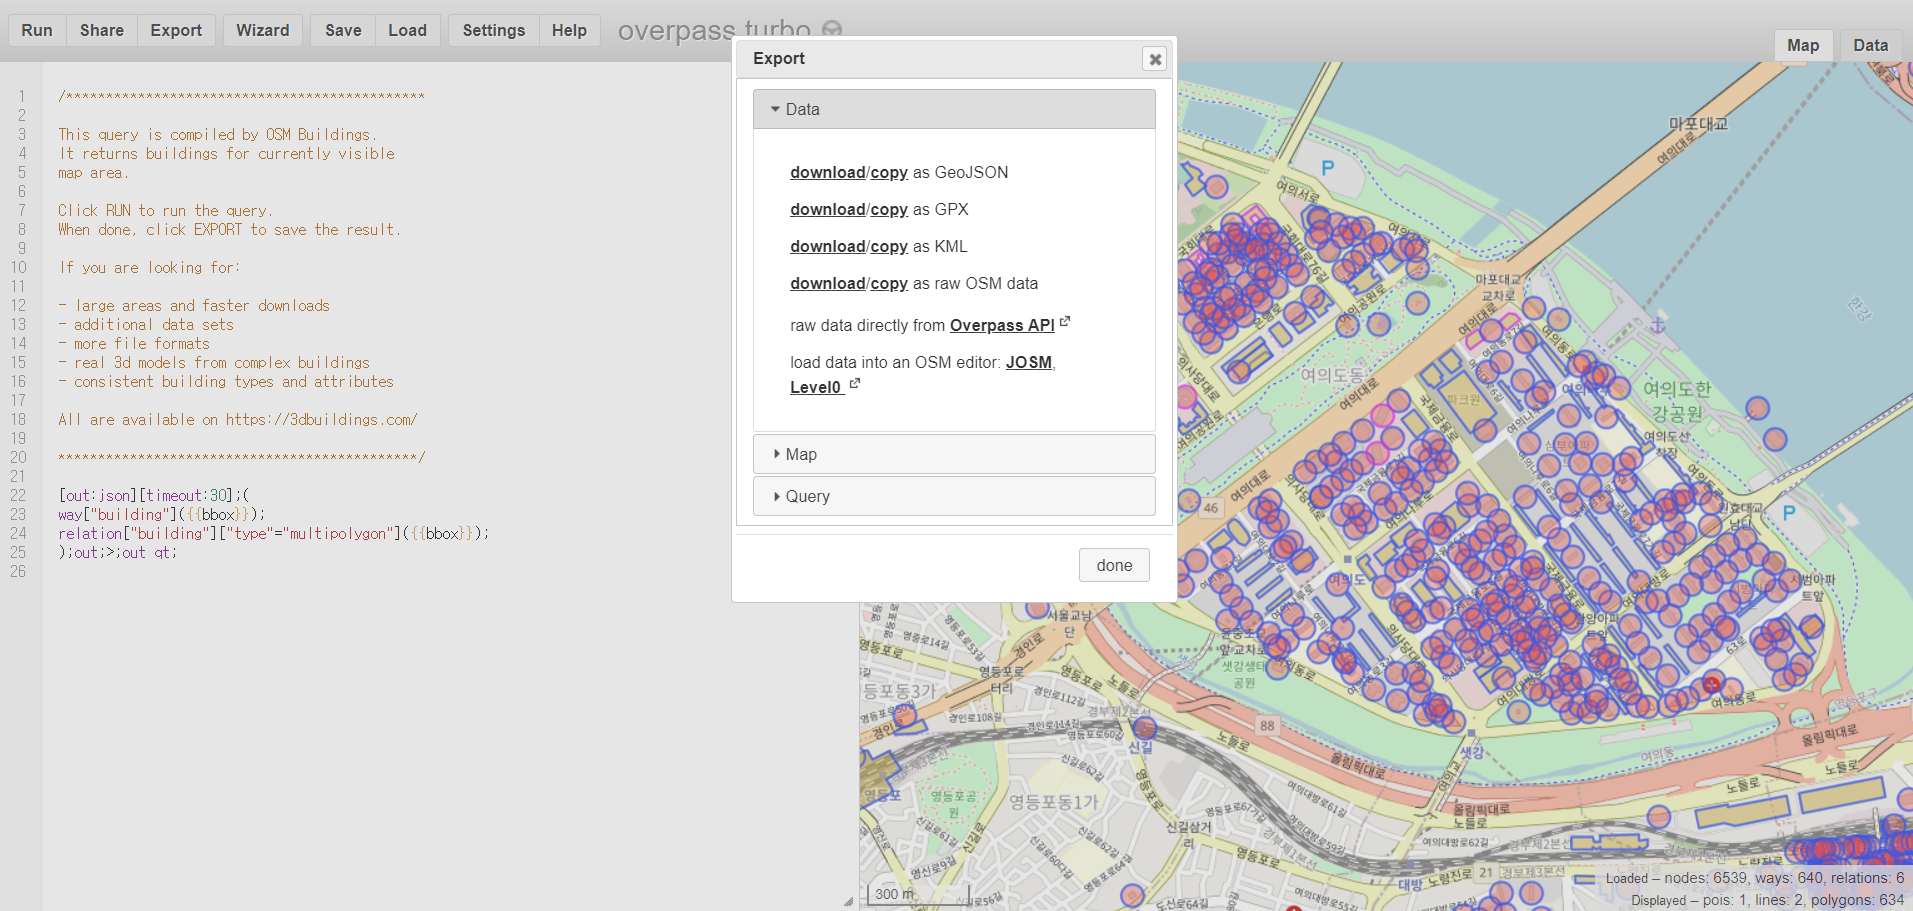


내려받은 파일을 테스트 해봅시다.  

- Kepler.gl 웹사이트에 접속합니다. https://kepler.gl/demo   


- 화면 가운데에 "Drag & Drop Your File(s) Here" 영역에 geojson 파일을 끌어다 놓습니다.  


- 지도 위에 건물이 표시되면 왼쪽의 export 레이어의 확장 아이콘 ∨ 을 클릭합니다.   


- Height를 On 상태로 바꿉니다. (모든 건물이 입체로 바뀝니다)  


-  ⁝ 을 클릭하여 "Height Based On"에 "height" 항목을 지정해줍니다. (건물 높이가 반영됩니다.)  


- 지도 화면 오른쪽 상단의 입체 상자 모양의 아이콘을 클릭하면 지도가 3D로 바뀝니다. 
 : 마우스 왼쪽 버튼은 지도 이동 , 스크롤 휠은 확대/축소, 오른쪽 버튼은 시점 변경입니다.     
 
 
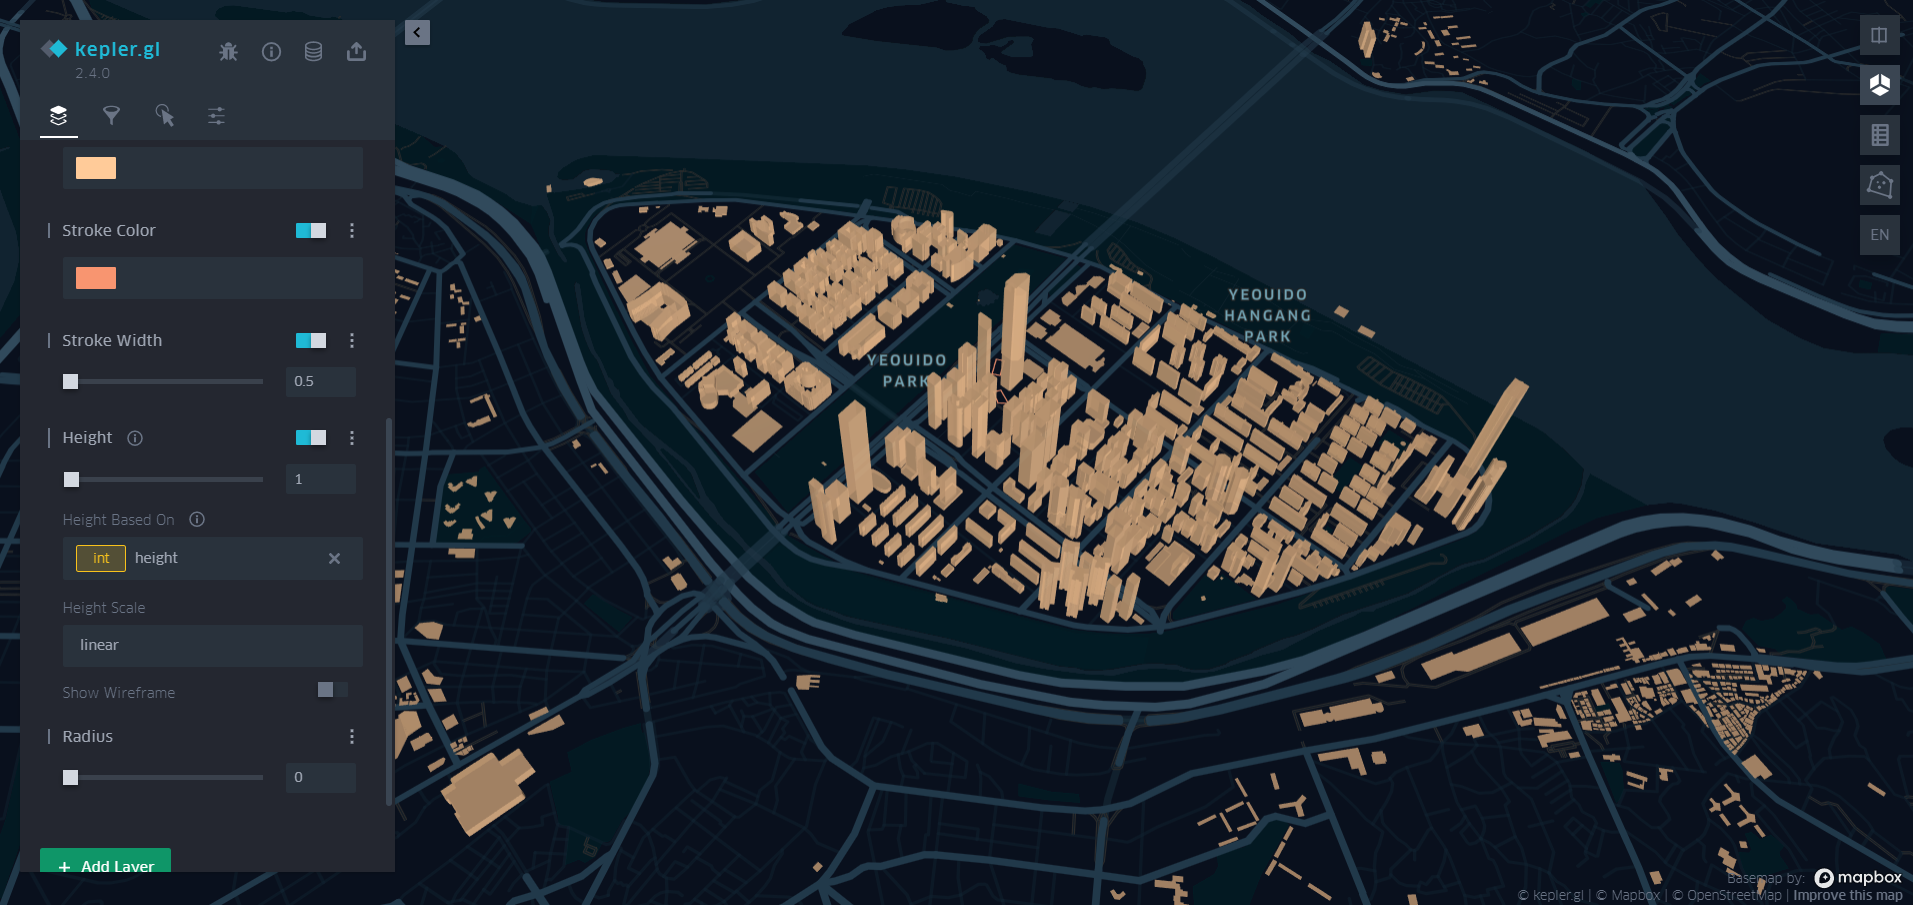 

- 구글맵(map.google.com)에 가서 건물을 추출한 지도 영역의 서남(좌하)측 좌표, 동북(우상)측 좌표, 중앙 3곳의 좌표를 확인하여 메모장에 복사  
  : 정확하지 않아도 됨  
  

### 3D 시각화

In [1]:
# mapbox token 정보 읽기 
f = open('../../etc/mapbox.txt', 'r')
lines = f.readlines()
mapbox_token = lines[0]

In [2]:
MAPBOX_API_KEY = mapbox_token.replace("'","")  #문자열의 홑따옴표 제거
MAPBOX_API_KEY2 = mapbox_token.replace('"','')  #문자열의 쌍따옴표 제거

윈도의 시스템 환경변수에 등록한 다음, 아래 코드처럼 적용해도 됩니다.   
MAPBOX_API_KEY = os.getenv('MAPBOX_ACCESS_TOKEN')

In [3]:
geo_data = './data/3D/export.geojson'

In [7]:
# 데이터 확인용 
df = gpd.read_file(geo_data)
df.head()

,id,@id,building,name,name:en,name:ja,type,building:levels,height,addr:city,...,name:jp,outdoor_seating,brand:ko,brand:wikipedia,construction,area,@relations,entrance,ref,geometry
0,relation/6033900,relation/6033900,yes,LG트윈타워,LG Twin Tower,LGツインタワー,multipolygon,None,None,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((126.92949 37.52816, 126.92951 ..."
1,relation/6924861,relation/6924861,apartments,강변삼성 아파트 101동,Gangbyun Samsung Apt. 101,None,multipolygon,22,None,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((126.94796 37.53412, 126.94828 37.533..."
2,relation/9467317,relation/9467317,officetel,진미파라곤,None,None,multipolygon,12,40,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((126.92067 37.53099, 126.92108 37.530..."
3,relation/9467328,relation/9467328,officetel,여의도LG에클라트,None,None,multipolygon,13,40,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((126.91922 37.52950, 126.91931 37.529..."
4,relation/9467365,relation/9467365,officetel,103동,None,None,multipolygon,13,42,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((126.91857 37.52592, 126.91861 37.525..."


In [8]:
LAND_COVER = [[[126.9070897, 37.512609], [126.9070897, 37.534526], [126.945674, 37.534526], [126.945674, 37.512609]]]
# 서남, 서북, 동북, 동남

INITIAL_VIEW_STATE = pdk.ViewState(latitude=37.525475, longitude=126.9244262, zoom=13, max_zoom=18, pitch=45, bearing=0)

polygon = pdk.Layer(
    "PolygonLayer",
    LAND_COVER,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 20],
)

geojson = pdk.Layer(
    "GeoJsonLayer",
    geo_data,
    opacity=0.75,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=False,
    get_elevation="properties.height * 1.2",
    get_fill_color="[properties.height * 2 - 255 , properties.height * 10 - 255 , properties.height * 20 - 255]",
    get_line_color=[255, 255, 255],
    pickable=True,
    auto_highlight=True
)

r = pdk.Deck(layers=[polygon, geojson], initial_view_state=INITIAL_VIEW_STATE)

#r.to_html("./result/geojson_layer.html")
r.show()

DeckGLWidget(google_maps_key=None, json_input='{"initialViewState": {"bearing": 0, "latitude": 37.525475, "lon…

### 참조   
https://deckgl.readthedocs.io/en/latest/gallery/geojson_layer.html  
https://dailyheumsi.tistory.com/147  

In [9]:
#pip install mapboxgl

In [12]:
import mapboxgl
#mapboxgl.__version__

In [13]:
from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops

In [14]:
geo_data = './data/gdf_gu_cctv_sl2.geojson'

# 파일을 파이썬에서 읽습니다.
import json
with open(geo_data, encoding='utf-8') as f:
    data = json.loads(f.read())

In [15]:
center = [126.986, 37.565]

# 시각화 할 값에 따른 색상의 범주를 지정해줍니다.
color_breaks = [0, 100, 300, 500, 700, 1500]
color_stops = create_color_stops(color_breaks, colors='YlGnBu')  #YlGnBu  BuPu

# ChoroplethViz 를 그립니다.
viz = ChoroplethViz(
    access_token=MAPBOX_API_KEY2,
    data=data,
    color_property='size',
    color_stops=color_stops,
    center=center,
    zoom=10)

# 맵을 출력합니다.
viz.show()

C:\Users\dhl\anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [16]:
from mapboxgl.utils import create_numeric_stops

# 맵을 -15도 만큼 좌우 회전하고, 45도 만큼 상하 회전합니다.
viz.bearing = -15
viz.pitch = 45
#viz.style = 'mapbox://styles/mapbox/light-v10?optimize=true'
viz.style = 'mapbox://styles/mapbox/dark-v10?optimize=true'

# 각 데이터에 '인구'를 기준으로 height 값을 줍니다.
viz.height_property = 'size'

numeric_stops = create_numeric_stops([0, 100, 300, 500, 700, 1500], 0, 3000)

viz.height_stops = numeric_stops
viz.height_function_type = 'interpolate'

# render again
viz.show()

- mapbox://styles/mapbox/streets-v11
- mapbox://styles/mapbox/outdoors-v11
- mapbox://styles/mapbox/light-v10
- mapbox://styles/mapbox/dark-v10
- mapbox://styles/mapbox/satellite-v9
- mapbox://styles/mapbox/satellite-streets-v11
- mapbox://styles/mapbox/navigation-preview-day-v4
- mapbox://styles/mapbox/navigation-preview-night-v4
- mapbox://styles/mapbox/navigation-guidance-day-v4
- mapbox://styles/mapbox/navigation-guidance-night-v4

* deckgl은 여러 개의 레이어를 쌓지 못함 > pydeck에서는 가능 

참조  
https://github.com/mapbox/mapboxgl-jupyter  


https://dailyheumsi.tistory.com/145  